**1. Library Imports**

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from nltk import bigrams
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report,accuracy_score,
confusion_matrix,ConfusionMatrixDisplay,roc_curve,auc,RocCurveDisplay)
from sentence_transformers import SentenceTransformer
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**2. Data Preparation**

In [2]:
# Load data
df = pd.read_csv("Combined_Data.csv")

# View columns to debug column mismatch
print("Columns:", df.columns)

# Rename correctly based on your actual file structure
df.columns = ['id', 'text', 'label']  # <-- Fixing the column mismatch
df = df[['text', 'label']]  # Keep only relevant columns

# Drop missing values
df.dropna(inplace=True)

# Preview data
df.head()


Columns: Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.describe()

,text,label
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    52681 non-null  object
 1   label   52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
df.shape

(52681, 2)

In [6]:
df.columns

Index(['text', 'label'], dtype='object')

In [7]:
df.info

<bound method DataFrame.info of                                                     text    label
0                                             oh my gosh  Anxiety
1      trouble sleeping, confused mind, restless hear...  Anxiety
2      All wrong, back off dear, forward doubt. Stay ...  Anxiety
3      I've shifted my focus to something else but I'...  Anxiety
4      I'm restless and restless, it's been a month n...  Anxiety
...                                                  ...      ...
53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040  Is there any way to sleep better? I can't slee...  Anxiety
53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042  I have really bad door anxiety! It's not about...  Anxiety

[52681 rows x 2 columns]>

In [8]:
df.describe()

,text,label
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


**3. Preprocessing**

In [9]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define full preprocessing function
def preprocess(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove digits
    text = re.sub(r'\d+', '', text)

    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin cleaned tokens into string
    return " ".join(tokens)


In [10]:
df['clean_text'] = df['text'].apply(preprocess)


In [11]:
print("Original Text:\n", df['text'].iloc[0])
print("\nCleaned Text:\n", df['clean_text'].iloc[0])


Original Text:
 oh my gosh

Cleaned Text:
 oh gosh


**4. Exploratary Data Analysis (EDA)**

**4.1 Label Distribution**

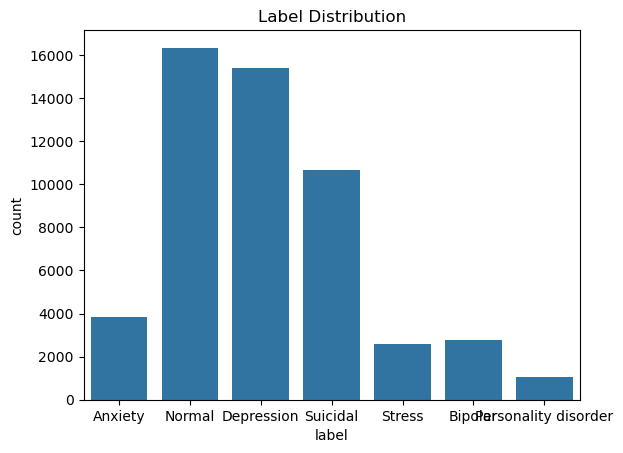

In [12]:
sns.countplot(data=df, x='label')
plt.title("Label Distribution")
plt.show()


**4.2 Text Length Distribution** 

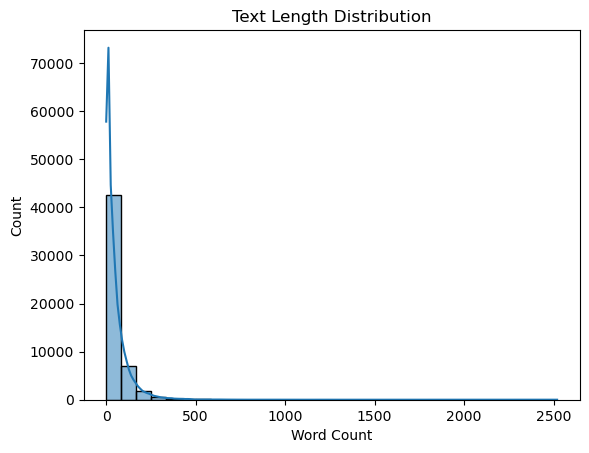

In [13]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], kde=True, bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.show()


**4.3 Boxplot Of text Length**

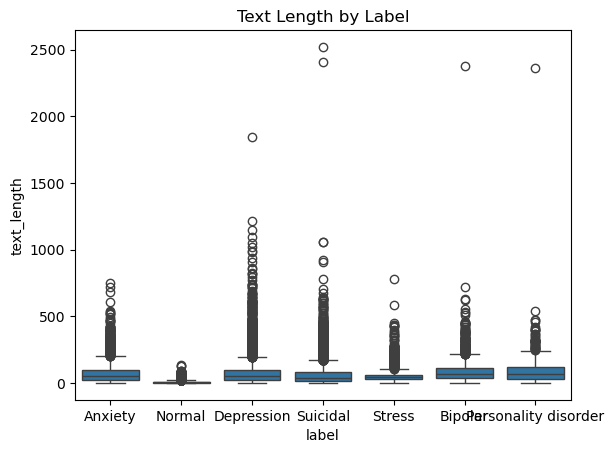

In [14]:
sns.boxplot(data=df, x='label', y='text_length')
plt.title("Text Length by Label")
plt.show()


**4.4 Word Frequency & Wordcloud**

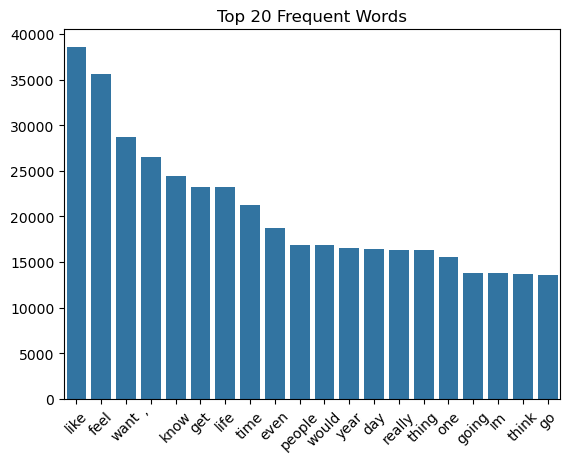

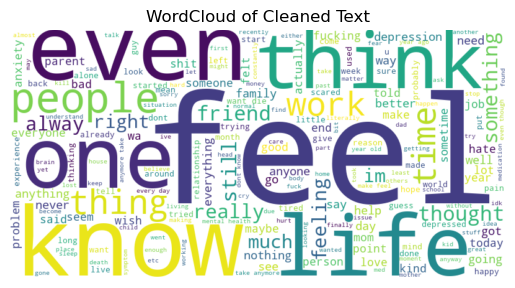

In [15]:
words = " ".join(df['clean_text']).split()
word_freq = Counter(words).most_common(20)

# Bar Plot
sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq])
plt.title("Top 20 Frequent Words")
plt.xticks(rotation=45)
plt.show()

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Cleaned Text")
plt.show()


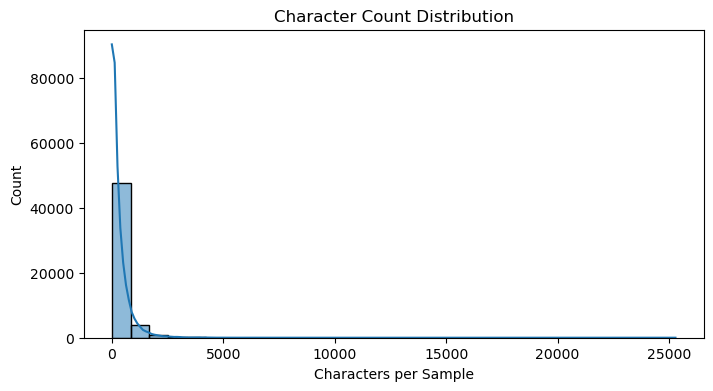

In [16]:
df['char_count'] = df['clean_text'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(df['char_count'], bins=30, kde=True)
plt.title("Character Count Distribution")
plt.xlabel("Characters per Sample")
plt.show()


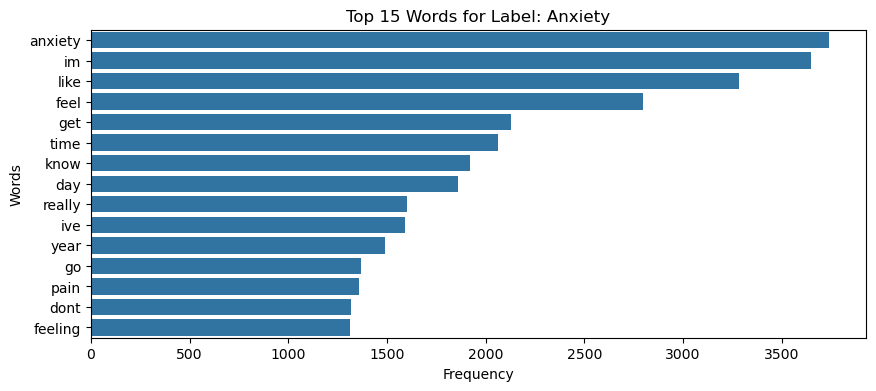

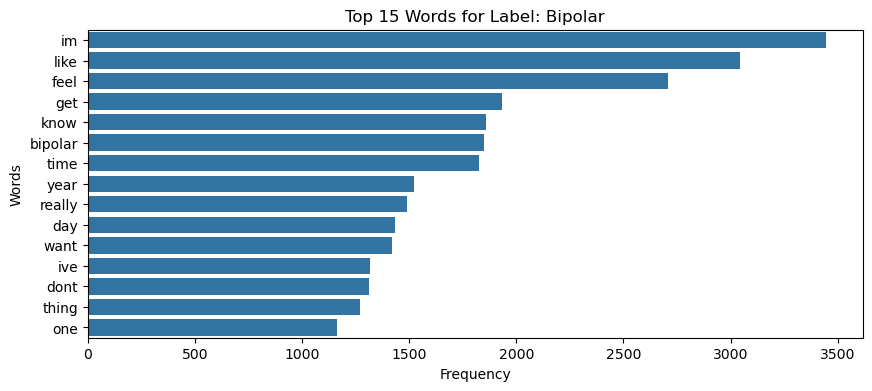

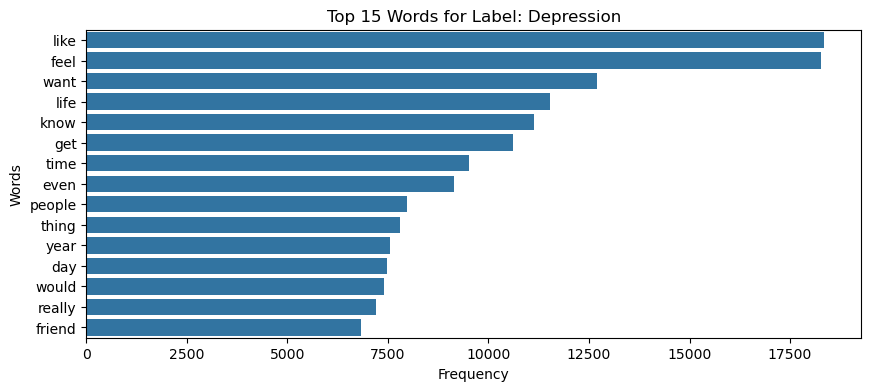

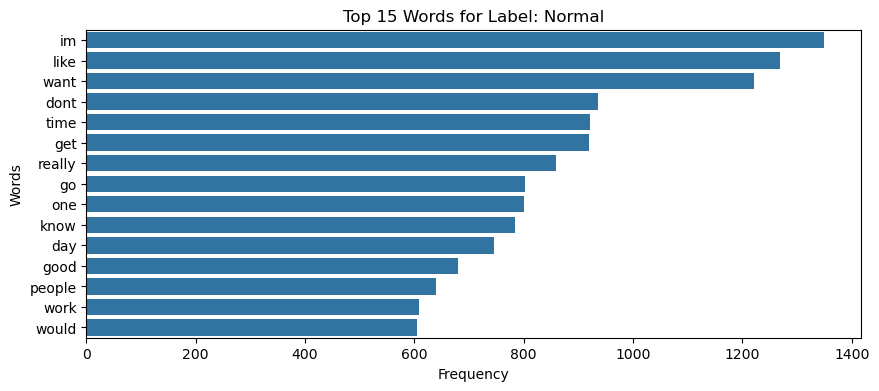

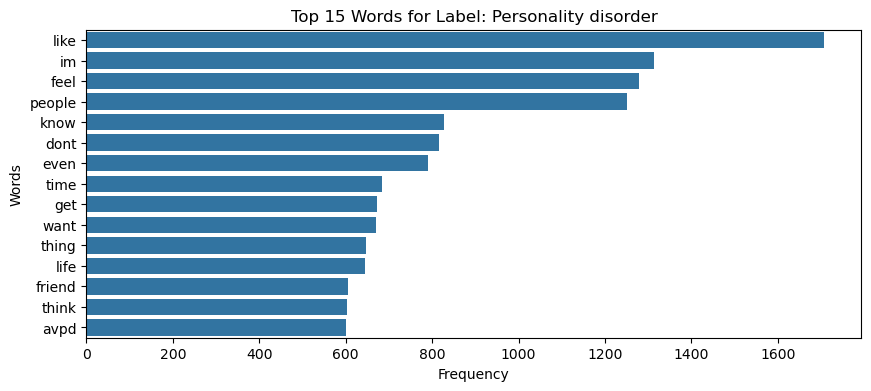

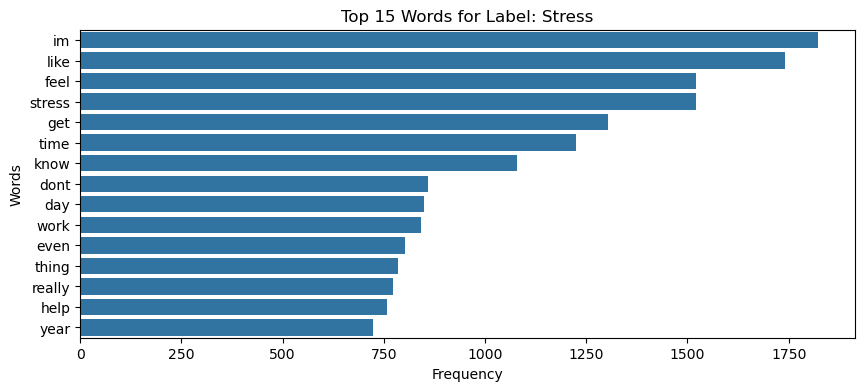

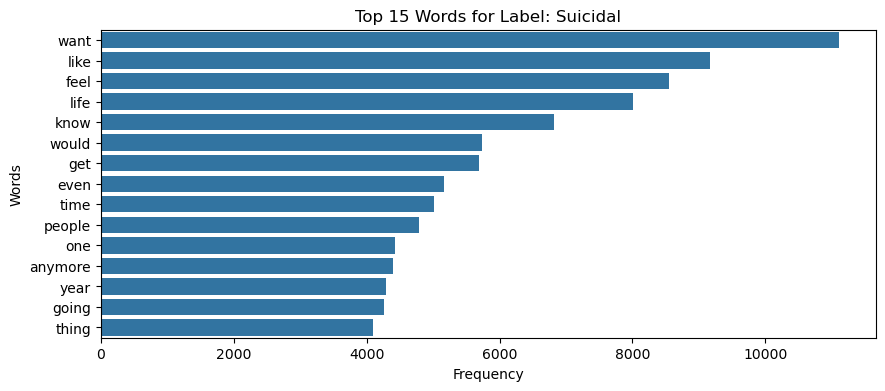

In [17]:
vectorizer = CountVectorizer(max_features=1000)
X_counts = vectorizer.fit_transform(df['clean_text'])
features = vectorizer.get_feature_names_out()

counts_df = pd.DataFrame(X_counts.toarray(), columns=features)
counts_df['label'] = df['label'].values

grouped = counts_df.groupby('label').sum().T

for label in grouped.columns:
    top_words = grouped[label].sort_values(ascending=False).head(15)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title(f"Top 15 Words for Label: {label}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()


**5 Model Building**

**5.1 Train test split**

In [18]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 42144
Test size: 10537


 **5.2 Text Vectorization with TF-IDF**

In [20]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

**5.3 Baseline model**

**5.3.1 Random Forest**

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # you can tune this
rf_model.fit(X_train_vec, y_train)

# === Predict ===
y_pred_rf = rf_model.predict(X_test_vec)
y_proba_rf = rf_model.predict_proba(X_test_vec)  # shape: (n_samples, n_classes)

# === Evaluation ===
print("🔹 Random Forest Report")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))



🔹 Random Forest Report
                      precision    recall  f1-score   support

             Anxiety       0.82      0.57      0.67       768
             Bipolar       0.95      0.53      0.68       556
          Depression       0.58      0.79      0.67      3081
              Normal       0.82      0.94      0.87      3269
Personality disorder       1.00      0.36      0.53       215
              Stress       0.89      0.27      0.41       517
            Suicidal       0.69      0.47      0.56      2131

            accuracy                           0.71     10537
           macro avg       0.82      0.56      0.63     10537
        weighted avg       0.73      0.71      0.69     10537

Accuracy: 0.7079813988801367


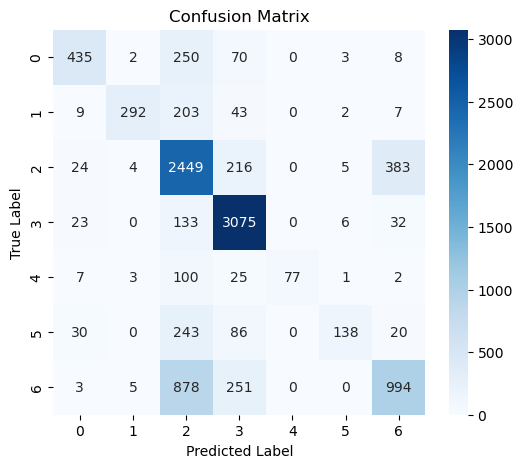

Accuracy: 0.7080
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.82      0.57      0.67       768
             Bipolar       0.95      0.53      0.68       556
          Depression       0.58      0.79      0.67      3081
              Normal       0.82      0.94      0.87      3269
Personality disorder       1.00      0.36      0.53       215
              Stress       0.89      0.27      0.41       517
            Suicidal       0.69      0.47      0.56      2131

            accuracy                           0.71     10537
           macro avg       0.82      0.56      0.63     10537
        weighted avg       0.73      0.71      0.69     10537



In [22]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy (TF-IDF + Random Forest): 0.7080
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.82      0.57      0.67       768
             Bipolar       0.95      0.53      0.68       556
          Depression       0.58      0.79      0.67      3081
              Normal       0.82      0.94      0.87      3269
Personality disorder       1.00      0.36      0.53       215
              Stress       0.89      0.27      0.41       517
            Suicidal       0.69      0.47      0.56      2131

            accuracy                           0.71     10537
           macro avg       0.82      0.56      0.63     10537
        weighted avg       0.73      0.71      0.69     10537

ROC AUC Score (multiclass, OVR): 0.9309


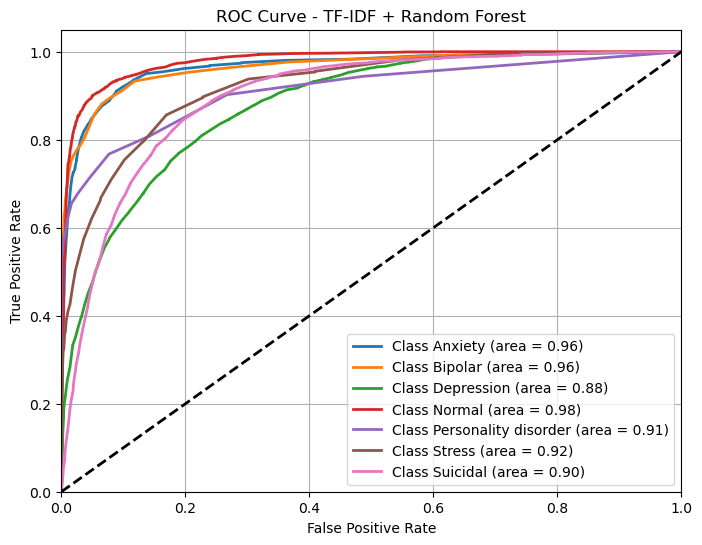

In [23]:
y_pred_rf = rf_model.predict(X_test_vec)
y_proba_rf = rf_model.predict_proba(X_test_vec)  # shape (n_samples, n_classes)
from sklearn.metrics import roc_auc_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (TF-IDF + Random Forest): {accuracy:.4f}")

# Classification report (optional)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Binarize the output labels for ROC curve plotting
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC AUC score (multiclass, one-vs-rest)
roc_auc = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
print(f"ROC AUC Score (multiclass, OVR): {roc_auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {c} (area = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TF-IDF + Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**5.4 Advance Model**

**5.4.1 Xgboost**

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_vec, y_train_enc)
y_pred_xgb = xgb.predict(X_test_vec)
y_proba_xgb = xgb.predict_proba(X_test_vec)
y_pred_labels = le.inverse_transform(y_pred_xgb)
y_test_labels = le.inverse_transform(y_test_enc)
print("Classification Report (XGBoost):")
print(classification_report(y_test_labels, y_pred_labels))

C:\Users\syeda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:07:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost):
                      precision    recall  f1-score   support

             Anxiety       0.81      0.72      0.76       768
             Bipolar       0.85      0.72      0.78       556
          Depression       0.70      0.73      0.71      3081
              Normal       0.83      0.94      0.88      3269
Personality disorder       0.88      0.59      0.70       215
              Stress       0.66      0.51      0.58       517
            Suicidal       0.68      0.61      0.64      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.69      0.72     10537
        weighted avg       0.75      0.76      0.75     10537



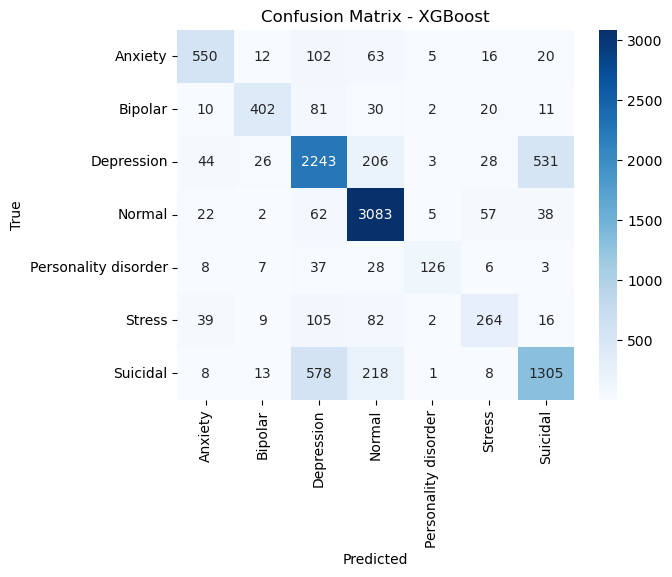

In [27]:
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

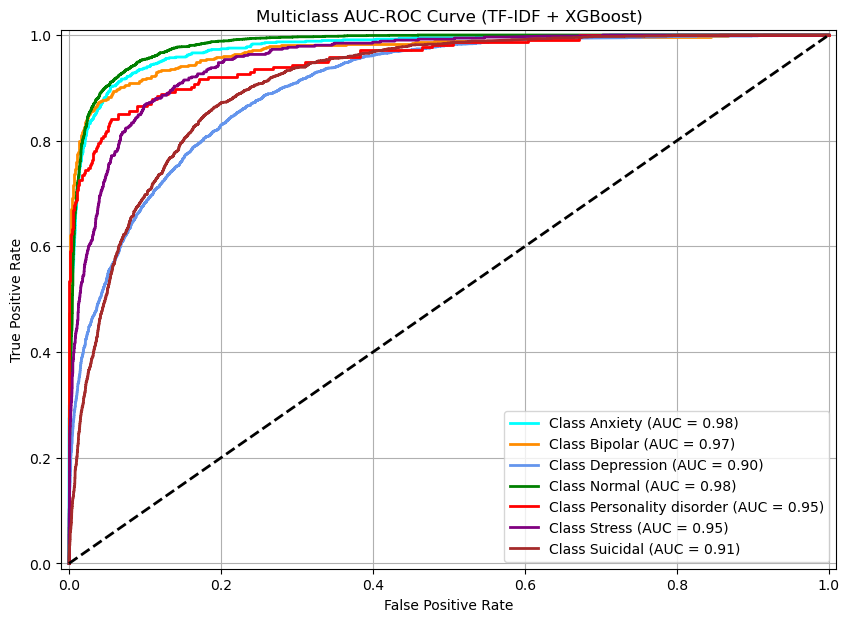

Macro AUC-ROC (XGBoost): 0.9497
Accuracy (XGBoost): 0.7567


In [28]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels
y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass AUC-ROC Curve (TF-IDF + XGBoost)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Compute and print overall macro AUC and accuracy
macro_auc = roc_auc_score(y_test_bin, y_proba_xgb, average="macro", multi_class="ovr")
y_pred_xgb = np.argmax(y_proba_xgb, axis=1)
acc = accuracy_score(y_test_enc, y_pred_xgb)

print(f"Macro AUC-ROC (XGBoost): {macro_auc:.4f}")
print(f"Accuracy (XGBoost): {acc:.4f}")


**5.4.2 Sbert + Xgboost**

In [29]:
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb = sbert_model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_emb = sbert_model.encode(X_test.tolist(), convert_to_numpy=True)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
xgb_model.fit(X_train_emb, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test_emb)
acc_xgb = accuracy_score(y_test_enc, y_pred_xgb)
print(f"SBERT + XGBoost Accuracy: {acc_xgb:.4f}")
print("Classification Report:\n", classification_report(y_test_enc, y_pred_xgb))

C:\Users\syeda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SBERT + XGBoost Accuracy: 0.7308
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       768
           1       0.87      0.69      0.77       556
           2       0.63      0.71      0.67      3081
           3       0.86      0.93      0.89      3269
           4       0.86      0.43      0.58       215
           5       0.70      0.44      0.54       517
           6       0.61      0.56      0.58      2131

    accuracy                           0.73     10537
   macro avg       0.76      0.64      0.69     10537
weighted avg       0.73      0.73      0.73     10537



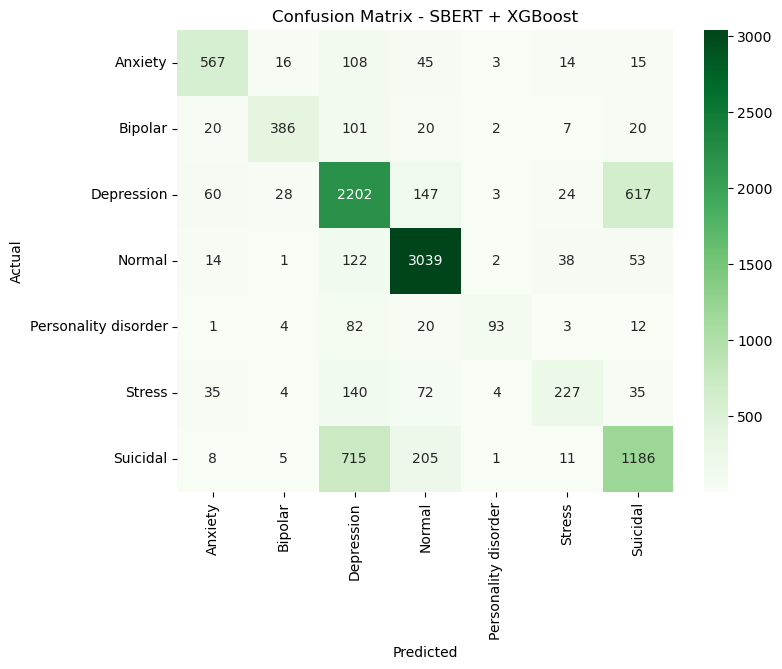

In [30]:
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SBERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


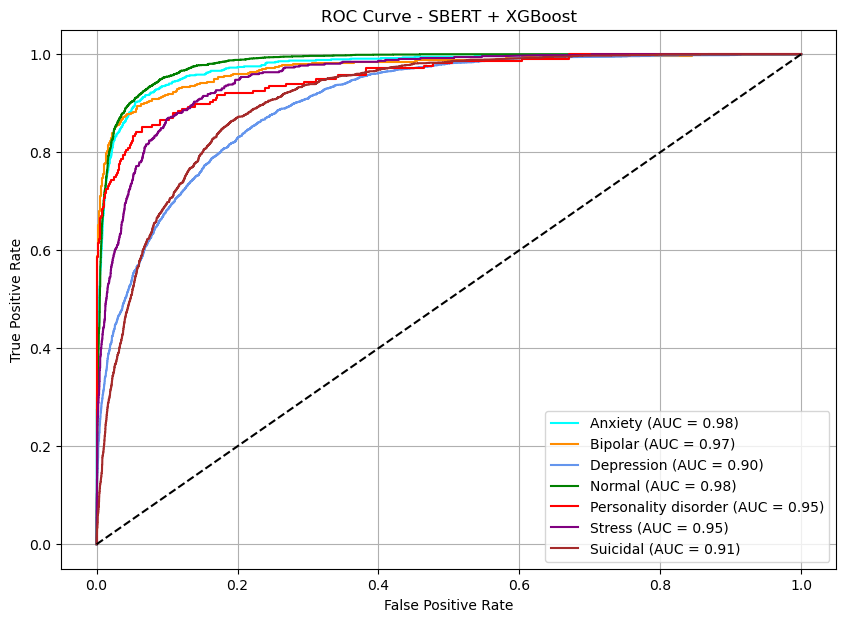

In [30]:
# ROC Curve for XGBoost
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SBERT + XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()


**5.4.4 Fine tuning Hyper Parameters**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(
objective="multi:softprob",
eval_metric="mlogloss",
use_label_encoder=False,
num_class=len(le.classes_), # important for multiclass
random_state=42
)
param_grid = {
"n_estimators": [100, 200],
"max_depth": [3, 5, 7],
"learning_rate": [0.01, 0.1],
"subsample": [0.8, 1.0],
"colsample_bytree": [0.8, 1.0]
}
grid_search = GridSearchCV(
estimator=xgb,
param_grid=param_grid,
scoring="accuracy",
cv=3,
verbose=2,
n_jobs=-1
)
grid_search.fit(X_train_emb, y_train_enc)
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Accuracy:", grid_search.best_score_)

In [ ]:
best_xgb_model = grid_search.best_estimator_
y_pred_test = best_xgb_model.predict(X_test_emb)

print(" Classification Report (Sentence-BERT + XGBoost):")
print(classification_report(y_test_enc, y_pred_test, target_names=le.classes_))

from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_test))

In [ ]:
cm = confusion_matrix(y_test_enc, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**5.5 Model Comparision**

In [36]:
classes = le.classes_
y_test_bin = label_binarize(y_test_enc, classes=range(len(classes)))  # shape: (n_samples, n_classes)
n_classes = y_test_bin.shape[1]


In [42]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

# ✅ TF-IDF + Random Forest
results["TFIDF + Random Forest"] = {
    "y_true": y_test_enc,   # encoded labels for consistency
    "y_pred": le.transform(y_pred_rf) if y_pred_rf.dtype.kind in {'U', 'S', 'O'} else y_pred_rf,
    "y_score": y_proba_rf,
    "accuracy": accuracy_score(y_test_enc, 
                                le.transform(y_pred_rf) if y_pred_rf.dtype.kind in {'U', 'S', 'O'} else y_pred_rf),
    "report": classification_report(
        y_test_enc,
        le.transform(y_pred_rf) if y_pred_rf.dtype.kind in {'U', 'S', 'O'} else y_pred_rf,
        output_dict=True
    )
}

# ✅ TF-IDF + XGBoost
results["TFIDF + XGBoost"] = {
    "y_true": y_test_enc,
    "y_pred": y_pred_xgb,
    "y_score": y_proba_xgb,
    "accuracy": accuracy_score(y_test_enc, y_pred_xgb),
    "report": classification_report(y_test_enc, y_pred_xgb, output_dict=True)
}

# ✅ SBERT + XGBoost
results["SBERT + XGBoost"] = {
    "y_true": y_test_enc,
    "y_pred": y_pred_xgb,
    "y_score": xgb_model.predict_proba(X_test_emb),
    "accuracy": accuracy_score(y_test_enc, y_pred_xgb),
    "report": classification_report(y_test_enc, y_pred_xgb, output_dict=True)
}


Skipping ROC for TFIDF + Random Forest due to error: multiclass format is not supported
Skipping ROC for TFIDF + XGBoost due to error: multiclass format is not supported
Skipping ROC for SBERT + XGBoost due to error: multiclass format is not supported


C:\Users\syeda\AppData\Local\Temp\ipykernel_43516\2987738794.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


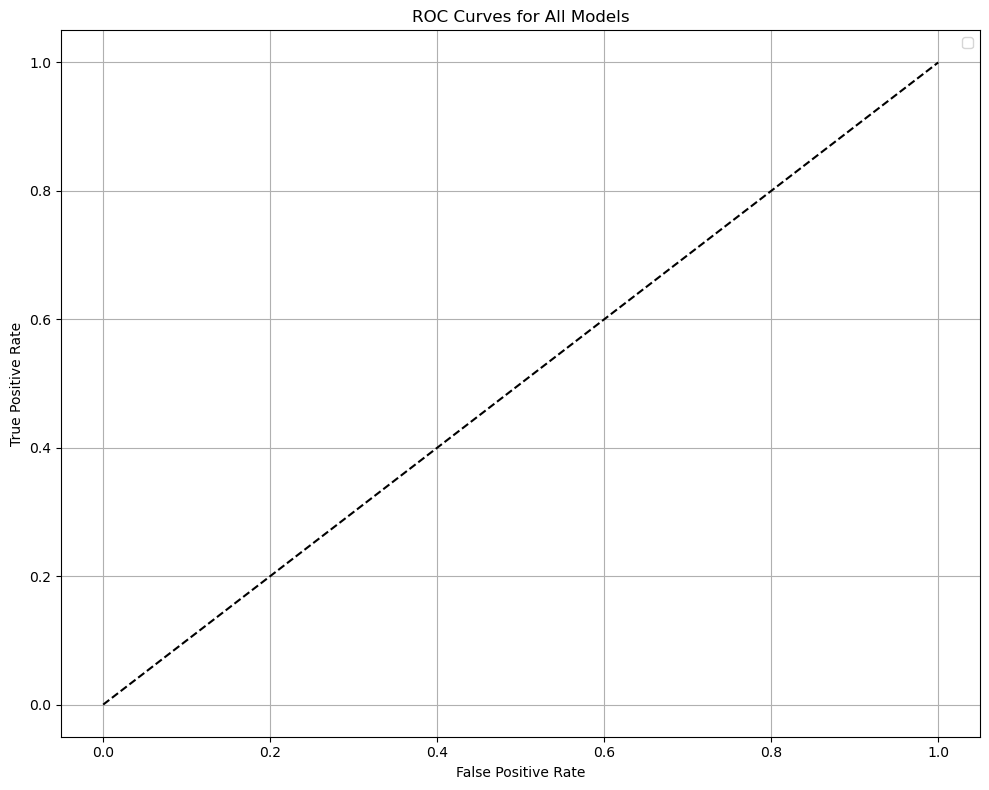

In [43]:
plt.figure(figsize=(10, 8))
for model_name, data in results.items():
    # Compute micro-average ROC AUC
    try:
        auc_score = roc_auc_score(data["y_true"], data["y_score"], average="macro", multi_class="ovr")
        fpr, tpr, _ = roc_curve(data["y_true"].ravel(), data["y_score"].ravel())
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
    except Exception as e:
        print(f"Skipping ROC for {model_name} due to error: {e}")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


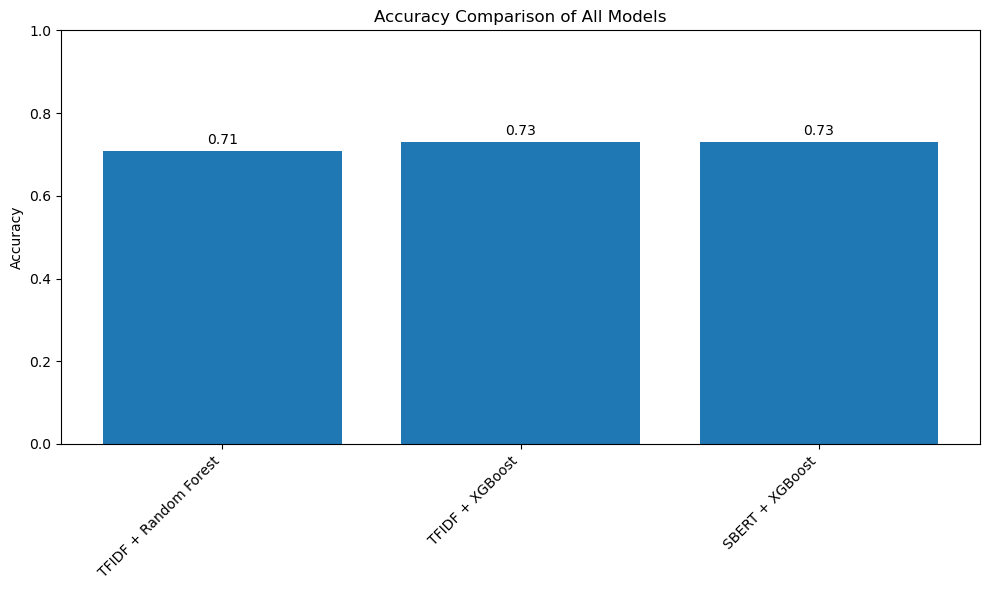

In [44]:
model_names = list(results.keys())
accuracies = [data["accuracy"] for data in results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.title("Accuracy Comparison of All Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)

# Label bars
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [45]:
from pandas import DataFrame

for model_name, data in results.items():
    print(f" Classification Report for {model_name}")
    df = DataFrame(data["report"]).transpose()
    display(df.round(2))


 Classification Report for TFIDF + Random Forest


,precision,recall,f1-score,support
0,0.82,0.57,0.67,768.00
1,0.95,0.53,0.68,556.00
2,0.58,0.79,0.67,3081.00
3,0.82,0.94,0.87,3269.00
4,1.00,0.36,0.53,215.00
5,0.89,0.27,0.41,517.00
6,0.69,0.47,0.56,2131.00
accuracy,0.71,0.71,0.71,0.71
macro avg,0.82,0.56,0.63,10537.00
weighted avg,0.73,0.71,0.69,10537.00


 Classification Report for TFIDF + XGBoost


,precision,recall,f1-score,support
0,0.80,0.74,0.77,768.00
1,0.87,0.69,0.77,556.00
2,0.63,0.71,0.67,3081.00
3,0.86,0.93,0.89,3269.00
4,0.86,0.43,0.58,215.00
5,0.70,0.44,0.54,517.00
6,0.61,0.56,0.58,2131.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.76,0.64,0.69,10537.00
weighted avg,0.73,0.73,0.73,10537.00


 Classification Report for SBERT + XGBoost


,precision,recall,f1-score,support
0,0.80,0.74,0.77,768.00
1,0.87,0.69,0.77,556.00
2,0.63,0.71,0.67,3081.00
3,0.86,0.93,0.89,3269.00
4,0.86,0.43,0.58,215.00
5,0.70,0.44,0.54,517.00
6,0.61,0.56,0.58,2131.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.76,0.64,0.69,10537.00
weighted avg,0.73,0.73,0.73,10537.00


In [46]:
import pandas as pd

# Automatically extract metrics from `results`
comparison_data = []
for model_name, data in results.items():
    report = data["report"]
    
    # Use 'weighted avg' for overall metrics
    weighted = report["weighted avg"]
    
    comparison_data.append({
        "Model": model_name,
        "Accuracy": data["accuracy"],
        "Precision": weighted["precision"],
        "Recall": weighted["recall"],
        "F1-score": weighted["f1-score"],
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)


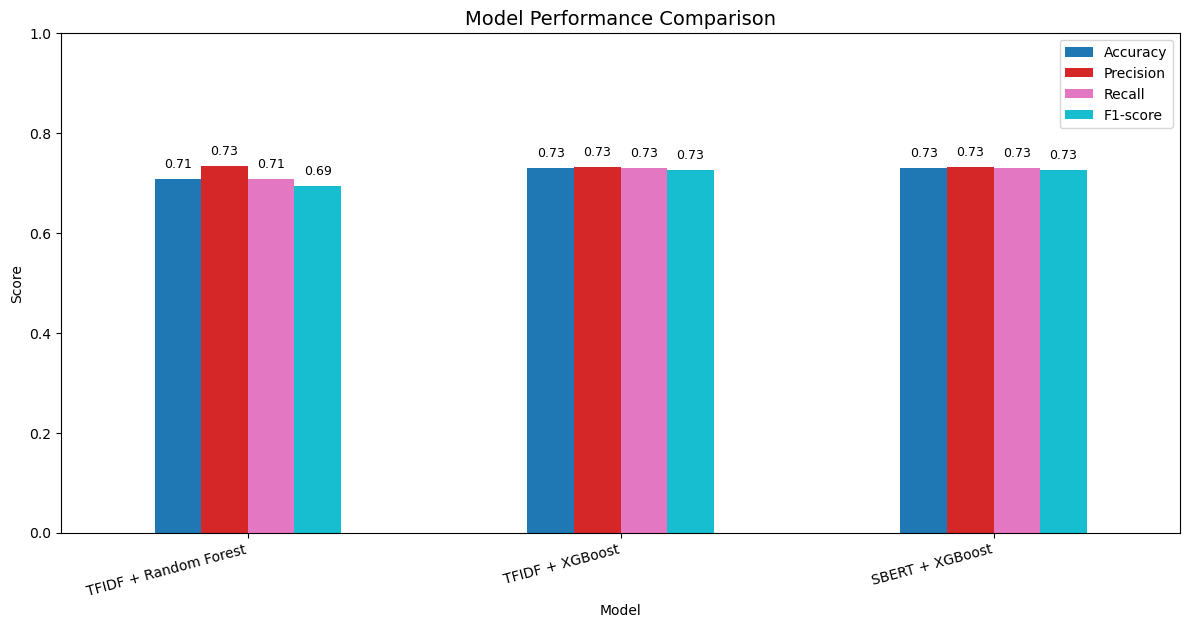

In [47]:
import matplotlib.pyplot as plt

# Bar plot of the metrics
ax = comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(
    kind='bar',
    figsize=(12, 6),
    ylim=(0, 1),
    colormap='tab10'
)

plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=15, ha='right')

# Add bar labels above the bars with more space and smaller font
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=6, fontsize=9)

# Optional: Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=1)  # make space for title if needed

plt.show()


In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # y_train is your original labels (e.g. categories)


LabelEncoder()

**6. Testing**

In [49]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from typing import Dict

sbert = SentenceTransformer('all-MiniLM-L6-v2')  # For label prediction

# Make sure these exist and are loaded somewhere globally:
# xgb_model = ... (your trained XGBoost model)
# label_encoder = ... (your fitted LabelEncoder)
# bert_model = sbert  # or another embedding model for score calculation

def clean_text(text: str) -> str:
    # Replace with your cleaning steps if needed
    return text.lower().strip()

def calculate_scores(text: str) -> Dict[str, float]:
    cleaned = clean_text(text)
    embedding = sbert.encode([cleaned])
    probabilities = xgb_model.predict_proba(embedding)[0]
    predicted_class = probabilities.argmax()

    confidence_score = probabilities[predicted_class] * 100
    stress_score = confidence_score

    uncertainty_score = (1 - probabilities.max()) * 100

    sentiment = TextBlob(text).sentiment.polarity
    sentiment_score = max(0, min(100, (sentiment + 1) * 50))

    emotion_intensity = abs(sentiment) * 100

    final_score = 0.4 * (100 - stress_score) + 0.6 * sentiment_score

    return {
        "confidence_score": round(confidence_score, 2),
        "stress_score": round(stress_score, 2),
        "mental_health_score": round(final_score, 2),
        "sentiment_score": round(sentiment_score, 2),
        "emotion_intensity": round(emotion_intensity, 2),
        "uncertainty_score": round(uncertainty_score, 2),
    }

def predict_label_and_scores(text: str) -> Dict:
    # Label prediction
    embedding = sbert.encode([text])
    pred_encoded = xgb_model.predict(embedding)
    predicted_label = label_encoder.inverse_transform(pred_encoded)[0]

    # Calculate scores
    scores = calculate_scores(text)

    # Return combined result
    return {
        "predicted_label": predicted_label,
        **scores
    }

# Example usage:
input_text = "I’ve been feeling really down lately. It’s like no matter what I do, I just can’t shake off this sadness. Sometimes I feel completely alone, even when I’m around people. My friends seem distant, and I don’t have the energy to reach out. I worry a lot about the future — whether I’m doing enough, if I’ll ever be happy, or if things will get better.On top of that, stress at work has been overwhelming. Deadlines keep piling up, and I feel like I’m constantly behind. Sleep has become a struggle because my mind won’t stop racing with worries,I get anxious about small things and often find myself crying unexpectedly"
result = predict_label_and_scores(input_text)
print(result)


{'predicted_label': 'Stress', 'confidence_score': 82.49, 'stress_score': 82.49, 'mental_health_score': 37.74, 'sentiment_score': 51.23, 'emotion_intensity': 2.46, 'uncertainty_score': 17.51}


**7. Save and Export Model**

In [2]:
import joblib

joblib.dump(xgb_model, "sbert_xgboost_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Models saved successfully.")


NameError: name 'xgb_model' is not defined

In [79]:
import os
import joblib

# Define the path to Desktop (cross-platform)
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "MindEase_model")

# Create folder if it doesn't exist
os.makedirs(desktop_path, exist_ok=True)

# Define full paths
model_path = os.path.join(desktop_path, "sbert_xgboost_model.pkl")
encoder_path = os.path.join(desktop_path, "label_encoder.pkl")

# Save model and encoder
joblib.dump(xgb_model, model_path)
joblib.dump(label_encoder, encoder_path)

print(f"Model and encoder saved to: {desktop_path}")


Model and encoder saved to: C:\Users\syeda\Desktop\MindEase_model


In [9]:
import joblib

# Load the model later
loaded_model = joblib.load("sbert_xgboost_model.pkl")



**More Tuning**

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(xgb, param_grid=param_grid, scoring="accuracy", cv=cv, ...)


In [32]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Encode target labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_emb, y_train_enc, test_size=0.2, random_state=42, stratify=y_train_enc
)

# Base model
xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=len(le.classes_),
    random_state=42,
    tree_method="hist"
)

# Expanded parameter search space
param_dist = {
    "n_estimators": randint(300, 500),
    "max_depth": randint(4, 8),
    "learning_rate": uniform(0.02, 0.08),
    "subsample": uniform(0.8, 0.2),
    "colsample_bytree": uniform(0.8, 0.2),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 3),
    "reg_alpha": uniform(0, 3),
    "min_child_weight": randint(1, 10)
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit with early stopping
search.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)

print("✅ Best Params:", search.best_params_)
print("✅ Best CV Accuracy:", search.best_score_)

# Retrain on full data with best params
best_params = search.best_params_
final_xgb = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=len(le.classes_),
    random_state=42,
    tree_method="hist"
)

final_xgb.fit(X_train_emb, y_train_enc)

# Accuracy
print("✅ Train Accuracy:", final_xgb.score(X_train_emb, y_train_enc))
print("✅ Test Accuracy:", final_xgb.score(X_test_emb, y_test_enc))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Params: {'colsample_bytree': 0.9295380241082725, 'gamma': 0.002601884976579094, 'learning_rate': 0.048205508506733524, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 497, 'reg_alpha': 1.5322419077326972, 'reg_lambda': 1.252233009446337, 'subsample': 0.8444215620941461}
✅ Best CV Accuracy: 0.7278658439545561
✅ Train Accuracy: 0.9768413059984814
✅ Test Accuracy: 0.7417671063870171


📊 Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.81      0.76      0.79       768
             Bipolar       0.87      0.70      0.78       556
          Depression       0.65      0.72      0.68      3081
              Normal       0.86      0.94      0.90      3269
Personality disorder       0.88      0.47      0.61       215
              Stress       0.73      0.44      0.55       517
            Suicidal       0.63      0.57      0.60      2131

            accuracy                           0.74     10537
           macro avg       0.78      0.66      0.70     10537
        weighted avg       0.74      0.74      0.74     10537



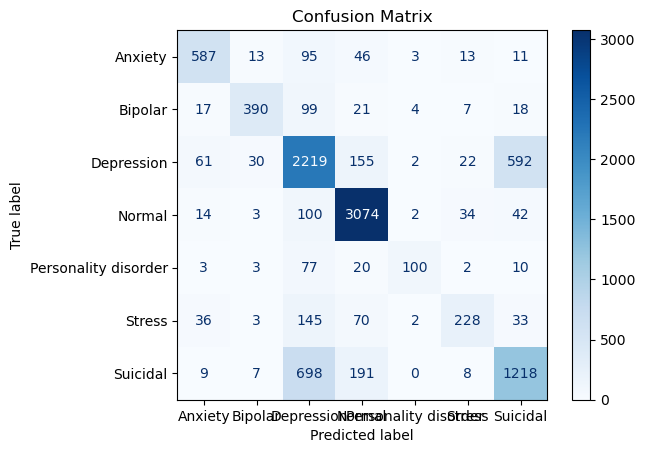

🏆 Macro-Averaged AUC: 0.9478


<Figure size 800x600 with 0 Axes>

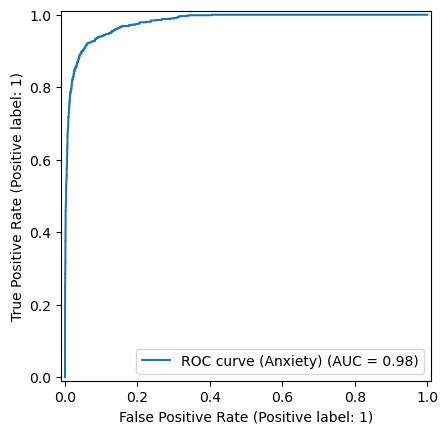

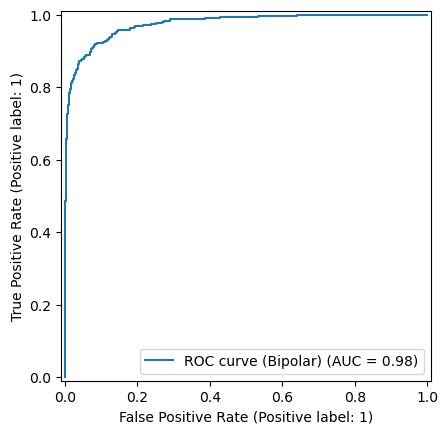

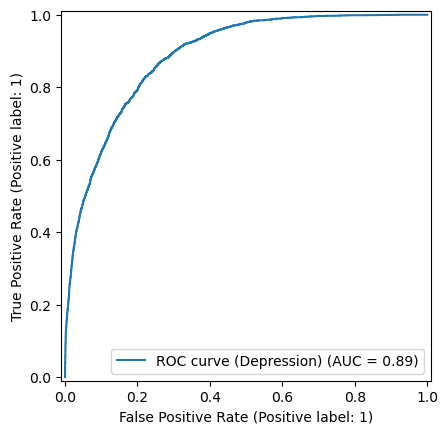

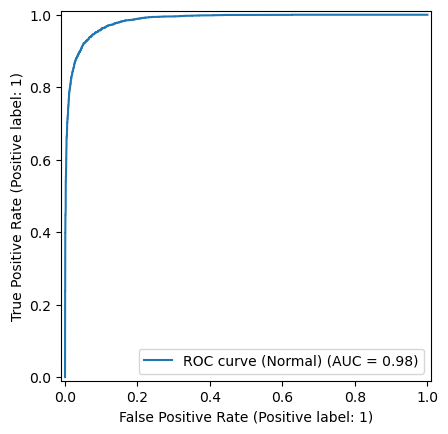

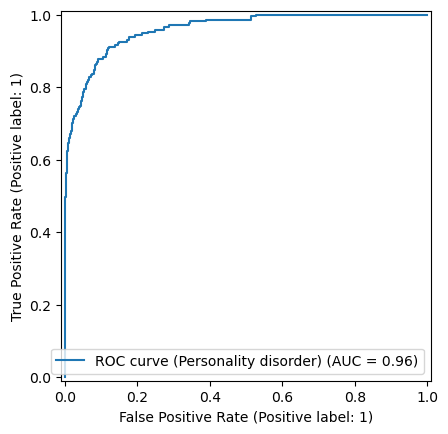

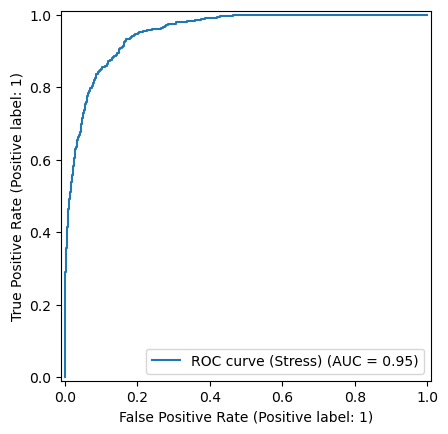

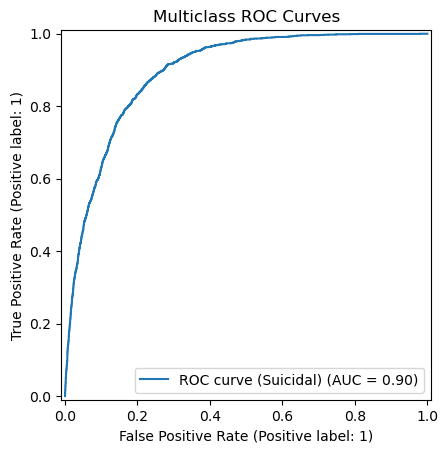

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# 1️⃣ Predictions
y_pred = final_xgb.predict(X_test_emb)
y_pred_proba = final_xgb.predict_proba(X_test_emb)

# 2️⃣ Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 4️⃣ AUC–ROC Curve (Multiclass)
# Binarize labels for ROC
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Compute macro-average AUC
auc_score = roc_auc_score(y_test_bin, y_pred_proba, average="macro", multi_class="ovr")
print(f"🏆 Macro-Averaged AUC: {auc_score:.4f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i], y_pred_proba[:, i], name=f"ROC curve ({le.classes_[i]})"
    )
plt.title("Multiclass ROC Curves")
plt.show()
